In [1]:
import numpy as np
import qutip as qt
import scipy as sp
import matplotlib
import matplotlib.pylab as plt
import krotov
import os.path
import random
from cmt import *
from matplotlib import rc
rc('font',**{'family':'serif','serif':['Computer Modern'], 'size':25})
rc('text', usetex=True)
plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]

/tmp/ipykernel_5903/1275055525.py:13: MatplotlibDeprecationWarning: Support for setting an rcParam that expects a str value to a non-str value is deprecated since 3.5 and support will be removed two minor releases later.
  plt.rcParams['text.latex.preamble']=[r"\usepackage{amsmath}"]


In [2]:
rank = 2 # rank of hamiltonian
kets = [qt.basis(2,i) for i in range(rank)]
projs = [qt.ket2dm(ket) for ket in kets]
c_ops =[]
psi0 = qt.fock(2,0)

e = 1.6e-19 #coulomb
h = 6.63e-34 *1e12/ e #eV ps
hbar = 1
hbar_eV = 6.582e-16 * 1e12 #eV ps
c = 3e8 * 1e-10 # cm/ps

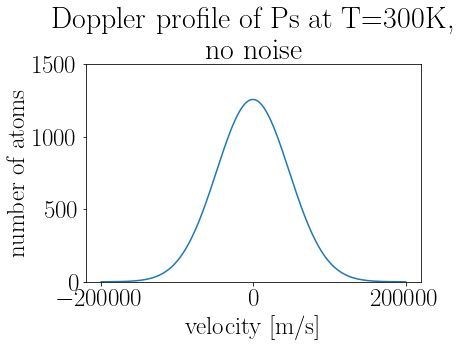

In [3]:
N_atoms = int(1e5)

T = 300 #K temperature of cloud
m = 2*9.1e-31 #kg
k = 1.38e-23 # [J K^-1]
std_deviation = np.sqrt(k*T/m) #standard deviation of gaussian
amplitude = np.sqrt(m/(2*np.pi*k*T))
N_bins = 267 #calculated such that 1 bin is the equivalent of 1 unit of photon momentum for Ps


velocity_bins = np.linspace(-2e5,2e5,N_bins) #m/s
populations = np.zeros(N_bins)
for i in range(N_bins-1):
    populations[i] = sp.integrate.quad(lambda v: amplitude*np.exp(-v**2/(2*std_deviation**2))*1e5,velocity_bins[i],velocity_bins[i+1])[0]
plt.plot(velocity_bins,populations)
plt.ylim(0,1500)
plt.xlabel("velocity [m/s]")
plt.ylabel("number of atoms")
plt.title("Doppler profile of Ps at T=300K,\n no noise")
plt.show()

In [4]:
velocity_bins = velocity_bins*1e-10 #cm/ps
# create new vector to track population: (velocity at bin, excited population)
data_in_bins = np.asarray([(velocity_bins[i],populations[i]) for i in range(N_bins)])
print(data_in_bins[150])

[2.55639098e-06 1.08019659e+03]


In [5]:
endTime =  20 #ps 
mass_ps = 1.022e6 # eV/ c^2 
wavelength = 243e-7 #cm
wavenumber = 2*np.pi/wavelength
momentum_per_photon = hbar_eV*wavenumber #eV ps cm^-1
velocity_change_per_photon = momentum_per_photon / mass_ps *c**2 #  cm/ps
print(velocity_change_per_photon, "cm/ps")
energy_splitting =  h*c/wavelength
omega0 = energy_splitting / hbar / hbar_eV# radians ps^-1
period = wavelength/c

binwidth = 2*np.pi/omega0*100
N_time = int(endTime/binwidth)
tlist = np.linspace(0,endTime,N_time)


pulse_duration = 10 #ps
tcentre = 10 #ps
tlist_centre = np.full(N_time,tcentre)



1.498728915411178e-07 cm/ps


In [6]:
#direction = +/-, depends on direction of incoming laser
def evolve(velocity_bins,pulse_kwargs):
    omega0 = pulse_kwargs["omega0"]
    detuning = pulse_kwargs["detuning"]
    chirp= pulse_kwargs["chirp"]
    rabi0= pulse_kwargs["rabi0"]
    pulse_duration = pulse_kwargs["pulse_duration"]
    direction = pulse_kwargs["direction"]
    
    rabi = lambda t, args: rabi0 * np.exp(-4*np.log(2)*(t-tcentre)**2/pulse_duration**2)
    
    final_states = []
    for vel in velocity_bins:
        H0 = hbar*qt.Qobj([[0,0],[0,omega0*direction*vel/c +detuning*(1+direction*vel/c)]])
        H_chirp = hbar*qt.Qobj([[0,0],[0,chirp*(1+direction*vel/c)]])
        H_transition = 0.5*hbar*qt.sigmax()
        H = [H0,[H_chirp,tlist-tlist_centre],[H_transition,rabi]]

        result = qt.mesolve(H, psi0,tlist,c_ops,e_ops=projs)
        #current_state = qt.Qobj([[result.expect[0][-1]],[result.expect[1][-1]]])
        final_states.append(result.expect[1][-1])
    
    return final_states 

In [27]:
rabi0 = 2*np.pi*(200e-3) #THz
detuning = 0#2*np.pi*(-152e-3) #THz
chirp = 2*np.pi*(70e-3) #THz

In [28]:
final_states = evolve(velocity_bins,omega0,detuning,chirp,rabi0,pulse_duration) 

0.38971085156409485


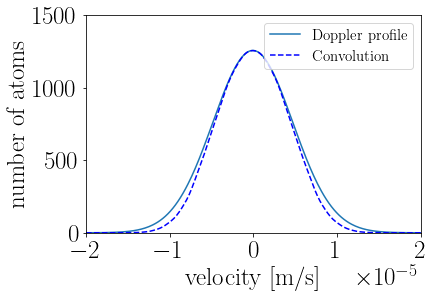

In [38]:
final_pops = np.asarray([np.abs(final_states[i][1][0][0]) for i in range(len(final_states))])
print(populations[5])
plt.plot(velocity_bins,populations,label="Doppler profile")
plt.plot(velocity_bins,final_pops*populations,color="blue",ls="dashed",label="Convolution")
plt.xlabel("velocity [m/s]")
plt.ylabel("number of atoms")
plt.ylim(0,1500)
plt.xlim(-2e-5,2e-5)
plt.legend(fontsize="15")
plt.show()

In [42]:
"""
detunings =  2*np.pi*np.asarray([-0.2,0,0.152,0.25])
final_pops = np.zeros((5,N_bins))
evolved_states = []
for i in range(detunings.size):
    evolved_states.append(evolve(omega0,detunings[i],chirp=0,rabi0=2*np.pi*(240e-3),pulse_duration=10))
    final_pops[i] = np.asarray([np.abs(evolved_states[i][j][1][0][0]) for j in range(N_bins)])
"""

'\ndetunings =  2*np.pi*np.asarray([-0.2,0,0.152,0.25])\nfinal_pops = np.zeros((5,N_bins))\nevolved_states = []\nfor i in range(detunings.size):\n    evolved_states.append(evolve(omega0,detunings[i],chirp=0,rabi0=2*np.pi*(240e-3),pulse_duration=10))\n    final_pops[i] = np.asarray([np.abs(evolved_states[i][j][1][0][0]) for j in range(N_bins)])\n'

In [41]:
"""
fig,axs = plt.subplots(detunings.size,3,figsize=(20,15))

for i in range(detunings.size):
    axs[i][0].hist(velocities,bins=N_bins,alpha=0.5,color="orange")
    axs[i][0].plot(velocity_bins,final_pops[i]*populations)
    axs[i][0].set_xlabel("velocity [cm/ps]")

    shifted_states = update_states(populations,evolved_states[i])
    axs[i][1].plot(velocity_bins, states[1],label="initial")
    axs[i][1].plot(velocity_bins,shifted_states,label="shifted")
    axs[i][1].set_xlabel("velocity [cm/ps]")
    #plt.legend()

    diffs = shifted_states - states[1]
    axs[i][2].plot(velocity_bins,diffs)
    axs[i][2].set_xlabel("velocity [cm/ps]")

    
    
fig.tight_layout()
plt.savefig("./figures/cmt/shifts.jpg")
plt.show()

"""

'\nfig,axs = plt.subplots(detunings.size,3,figsize=(20,15))\n\nfor i in range(detunings.size):\n    axs[i][0].hist(velocities,bins=N_bins,alpha=0.5,color="orange")\n    axs[i][0].plot(velocity_bins,final_pops[i]*populations)\n    axs[i][0].set_xlabel("velocity [cm/ps]")\n\n    shifted_states = update_states(populations,evolved_states[i])\n    axs[i][1].plot(velocity_bins, states[1],label="initial")\n    axs[i][1].plot(velocity_bins,shifted_states,label="shifted")\n    axs[i][1].set_xlabel("velocity [cm/ps]")\n    #plt.legend()\n\n    diffs = shifted_states - states[1]\n    axs[i][2].plot(velocity_bins,diffs)\n    axs[i][2].set_xlabel("velocity [cm/ps]")\n\n    \n    \nfig.tight_layout()\nplt.savefig("./figures/cmt/shifts.jpg")\nplt.show()\n\n'

In [43]:
"""
diff = np.asarray(states[1]-states_after_one_pulse[1])
plt.plot(velocity_bins, diff)
plt.ylabel("difference between populations")
plt.xlabel("velocity [cm/ps]")
"""

'\ndiff = np.asarray(states[1]-states_after_one_pulse[1])\nplt.plot(velocity_bins, diff)\nplt.ylabel("difference between populations")\nplt.xlabel("velocity [cm/ps]")\n'

In [21]:
# momentum is +/- 1 units of photon momentum,
# and depends on the direction of the incoming laser.
def update_states(pops, transitions, momentum):
    temp_pops = pops
    new_pops = np.zeros(N_bins)
    for i in range(2,N_bins-2):
        new_pops[i] = temp_pops[i]*(1-transitions[i]) + temp_pops[i+momentum]*transitions[i+momentum]
    return new_pops

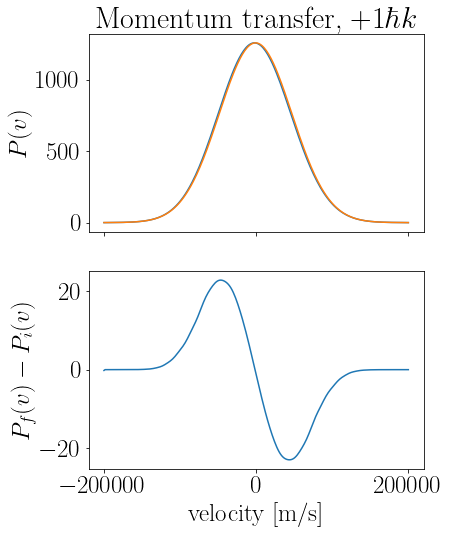

In [71]:
new_population = update_states(populations,final_states,+1)
fig,axs = plt.subplots(2,figsize=(6,8),sharex=True)

axs[0].plot(velocity_bins*1e10,new_population)
axs[0].plot(velocity_bins*1e10,populations)
axs[1].plot(velocity_bins*1e10,new_population-populations)
axs[1].set_xlabel("velocity [m/s]")
axs[0].set_ylabel(r"$P(v)$")
axs[1].set_ylabel(r"$P_f(v)-P_i(v)$")
axs[0].set_title(r"Momentum transfer, $+1\hbar k$")
plt.savefig("figures/cmt/momentum_transfer_plus_one.jpg")
plt.show()

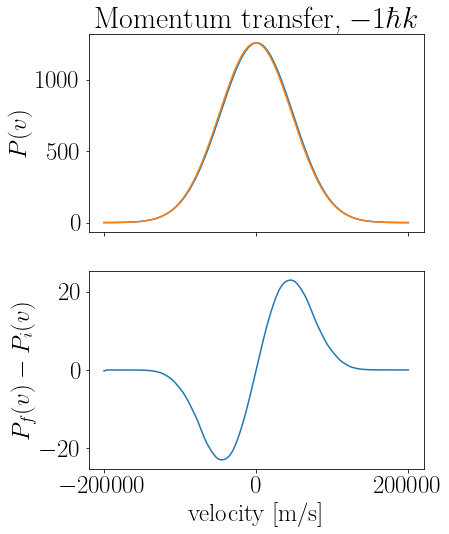

In [72]:
new_population = update_states(populations,final_states,-1)
fig,axs = plt.subplots(2,figsize=(6,8),sharex=True)

axs[0].plot(velocity_bins*1e10,new_population)
axs[0].plot(velocity_bins*1e10,populations)
axs[1].plot(velocity_bins*1e10,new_population-populations)
axs[1].set_xlabel("velocity [m/s]")
axs[0].set_ylabel(r"$P(v)$")
axs[1].set_ylabel(r"$P_f(v)-P_i(v)$")
axs[0].set_title(r"Momentum transfer, $-1\hbar k$")
plt.savefig("figures/cmt/momentum_transfer_minus_one.jpg")
plt.show()

In [8]:
pump_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(-152e-3),"chirp" : 0,"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":+1}
dump_pulse_dict = {"rabi0" : 2*np.pi*(240e-3), "detuning": 2*np.pi*(152e-3),"chirp" : 0,"pulse_duration" : 10 , "omega0" : energy_splitting / hbar / hbar_eV,"direction":-1}
transitions_pump = evolve(velocity_bins,pump_pulse_dict)
transitions_dump = evolve(velocity_bins,dump_pulse_dict)

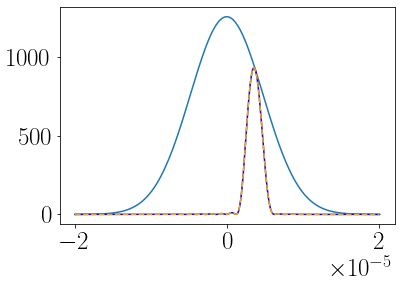

In [22]:
#pops_pump = np.abs([transitions_pump[i][1][0][0] for i in range(N_bins)])
#pops_dump = np.abs([transitions_dump[i][1][0][0] for i in range(N_bins)])
plt.plot(velocity_bins,populations)
plt.plot(velocity_bins,transitions_pump*populations,color="blue")
plt.plot(velocity_bins,transitions_dump*populations,color="orange",ls="dashed")
plt.show()

In [23]:

def pump_dump_cycle(initial_pops,time_ordered_pulse_train):
    temp_pops = initial_pops
    for pulse in time_ordered_pulse_train:
        if pulse == "pump":
            transitions = transitions_pump
            momentum_change = 1 
        elif pulse == "dump":
            transitions = transitions_dump
            momentum_change = 1
      
        temp_pops = update_states(temp_pops,transitions,momentum_change)
    
    new_pops = temp_pops
    return new_pops


Initial number of atoms: 99997 Final number of atoms: 99996


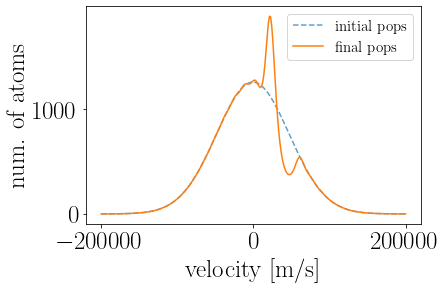

In [37]:
train = ["pump","dump"]
N_cycles = 3
pops = populations
for i in range(N_cycles):
    pops = pump_dump_cycle(pops,train)
    
print("Initial number of atoms:", int(np.sum(populations)), "Final number of atoms:", int(np.sum(pops)))
# where isn't there more population in the middle? the number of total atoms is reduced
plt.plot(velocity_bins*1e10,populations,label="initial pops",ls="dashed",alpha=0.7)
plt.plot(velocity_bins*1e10,pops, label="final pops")
plt.xlabel("velocity [m/s]")
plt.ylabel("num. of atoms")
plt.legend(fontsize="15")
plt.title("")
plt.show()